In [1]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt

2:51pm

In [6]:
def my_proposal(x_t):
    x_prime = sps.norm.rvs(loc=x_t, scale=1.)
    return x_prime

def my_f(x):
    a = 3.*sps.norm.pdf(x, loc=5, scale=2)
    b = sps.norm.pdf(x, loc=2.4, scale=0.6)
    return a+b

def my_target(x):
    return my_f(x)/4.

In [15]:
n_steps = 10000

x_t = 0.
x_bag = []
for ind_step in range(n_steps):
    x_prime = my_proposal(x_t)

    acceptance_ratio = my_f(x_prime)/my_f(x_t)
    u = np.random.uniform(low=0, high=1)

    if (u<=acceptance_ratio):
        x_bag.append(x_prime)

        # update
        x_t = x_prime
    else:
        x_bag.append(x_t)

Text(0, 0.5, 'X')

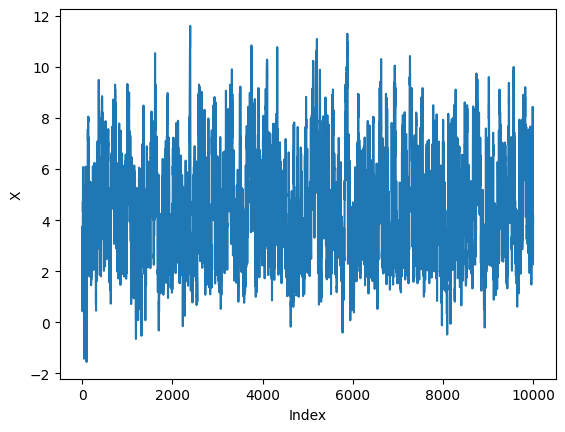

In [16]:
plt.plot(x_bag)
plt.xlabel('Index')
plt.ylabel('X')

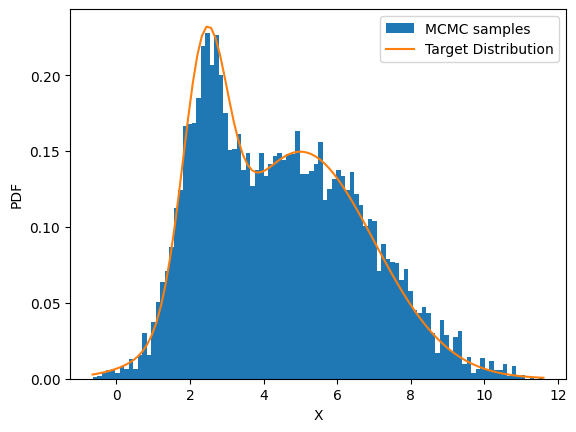

In [26]:
x_select = x_bag[1000:]
nbins = 100
xx_plot = np.linspace(min(x_select), max(x_select), 100)
plt.hist(x_select, bins=nbins, density=True, label='MCMC samples')
plt.plot(xx_plot, my_target(xx_plot), label='Target Distribution')
plt.xlabel('X')
plt.ylabel('PDF')
plt.legend()

3:02 pm, 3:07 pm